# Descripción de las anotaciones

In [31]:
import math
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from config import DATA_PATH, VISUALIZATIONS_PATH
from utilities import save_dataframe

## Preprocesado

In [32]:
out_file = os.path.join(DATA_PATH, "tokens2tag_as_stopw.csv")
tokens2tag = pd.read_csv(
    out_file,
    converters={"pos": eval, "lemmas": eval},
    usecols=["raw", "F", "f", "lemmas", "pos", "use", "pos_correction"]
)
tokens2tag.head()

,raw,F,f,lemmas,pos,use,pos_correction
0,abandonar,1.0,0.000014,[abandonar],[VERB],lemma,NaN
1,abarca,2.0,0.000028,[abarcar],[VERB],lemma,NaN
2,abordado,2.0,0.000028,[abordar],[VERB],lemma,NaN
3,abordamos,1.0,0.000014,[abordar],[VERB],lemma,NaN
4,abordan,1.0,0.000014,[abordar],[VERB],lemma,NaN


In [33]:
# cantidad de tokens únicos
tokens2tag.shape[0]

7424

In [34]:
# cantidad de tokens totales
tokens2tag.F.sum()

71632.0

In [35]:
def is_corrected_lemma(row: pd.Series)  -> str:
    if row.use == "lemma":
        return False
    else:
        return True
    
def is_corrected_pos(row: pd.Series)  -> str:
    if isinstance(row.pos_correction, str):
        return True
    else:
        return False

def select_lemma(row: pd.Series) -> str:
    if row.use == "lemma":
        return row.lemmas[0]
    elif row.use == "FALSE":
        return None
    else:
        return row.use
    
def select_pos(row: pd.Series) -> str:
    if isinstance(row.pos_correction, str):
        return row.pos_correction
    else:
        return row.pos[0]

def lemma_is_in_prediction(row: pd.Series) -> bool:
    if row.use == "lemma":
        return True
    else:
        if row.use in row.lemmas:
            return True
        else:
            return False
    
def pos_is_in_prediction(row: pd.Series) -> bool:
    if isinstance(row.pos_correction, str):
        if row.pos_correction in row.pos:
            return True
        else:
            return False
    else:
        return True

In [36]:
tokens2tag = (
    tokens2tag
    .assign(
        lemma_corrected=tokens2tag.apply(is_corrected_lemma, axis=1),
        pos_corrected=tokens2tag.apply(is_corrected_pos, axis=1),
        selected_lemma=tokens2tag.apply(select_lemma, axis=1),
        selected_pos=tokens2tag.apply(select_pos, axis=1),
        selected_lemma_in_prediction=tokens2tag.apply(lemma_is_in_prediction, axis=1),
        selected_pos_in_prediction=tokens2tag.apply(pos_is_in_prediction, axis=1)
    )
)
tokens2tag.head()

,raw,F,f,lemmas,pos,use,pos_correction,lemma_corrected,pos_corrected,selected_lemma,selected_pos,selected_lemma_in_prediction,selected_pos_in_prediction
0,abandonar,1.0,0.000014,[abandonar],[VERB],lemma,NaN,False,False,abandonar,VERB,True,True
1,abarca,2.0,0.000028,[abarcar],[VERB],lemma,NaN,False,False,abarcar,VERB,True,True
2,abordado,2.0,0.000028,[abordar],[VERB],lemma,NaN,False,False,abordar,VERB,True,True
3,abordamos,1.0,0.000014,[abordar],[VERB],lemma,NaN,False,False,abordar,VERB,True,True
4,abordan,1.0,0.000014,[abordar],[VERB],lemma,NaN,False,False,abordar,VERB,True,True


## Métricas de resumen

In [37]:
FOLDER = os.path.join(VISUALIZATIONS_PATH, "tokens2tag")
os.makedirs(FOLDER, exist_ok=True)

#### Tokens despreciados

In [38]:
# tokens que se desprecian
tokens2remove = tokens2tag[tokens2tag.use == "FALSE"]

print(f"Cantidad de tokens únicos: {tokens2remove.raw.count()}")
print(f"Porcentaje sobre el total de tokens: {round(tokens2remove.f.sum()*100, 3)}%")
tokens2remove_pos = (
    tokens2remove
    .selected_pos
    .value_counts(normalize=True)
    .to_frame(name="freq")
    .reset_index(names=["POS"])
    .assign(freq=lambda x: x.freq*100)
)
save_dataframe(
    tokens2remove,
    VISUALIZATIONS_PATH, "tokens2remove_pos_freq",
    latex=True
)
tokens2remove_pos

Cantidad de tokens únicos: 195
Porcentaje sobre el total de tokens: 1.819%


,POS,freq
0,NUM,90.769231
1,PROPN,4.615385
2,PUNCT,2.051282
3,SYM,1.538462
4,CCONJ,0.512821
5,ADP,0.512821


#### Lemmas corregidos

In [39]:
# cantidad de lemmas corregidos

tokens2tag = tokens2tag[tokens2tag.use != "FALSE"]
tokens2tag_corrected_lemmas = (
    tokens2tag
    .groupby(["lemma_corrected", "selected_lemma_in_prediction"])
    .size()
    .to_frame(name="count")
    .reset_index()
    .assign(
        perc=lambda x: (x["count"]/x["count"].sum())*100
    )
)
save_dataframe(
    tokens2tag_corrected_lemmas,
    FOLDER, "tokens2tag_corrected_lemmas.csv",
    latex=True
)
tokens2tag_corrected_lemmas

,lemma_corrected,selected_lemma_in_prediction,count,perc
0,False,True,5760,79.679070
1,True,False,1040,14.386499
2,True,True,429,5.934431


In [40]:
# cantidad de POS (tomando en cuenta las correcciones)
# en los lemmas corregidos
tokens2tag_pos_lemmas_in_pred = (
    tokens2tag[tokens2tag.lemma_corrected]
    .value_counts("selected_pos")
    .to_frame(name="total")
    .reset_index()
    .assign(
        perc=lambda x: (x.total/x.total.sum())*100
    )
    .merge(
        (
            tokens2tag
            [tokens2tag.lemma_corrected]
            .groupby(["selected_pos","selected_lemma_in_prediction"])
            .size()
            .to_frame(name="pos_count")
            .reset_index()
        )
    )
    .assign(
        pos_perc=lambda x: (x.pos_count/x.total)*100
    )
    .sort_values(by=["total", "pos_count"], ascending=False, ignore_index=True)
)
save_dataframe(
    tokens2tag_pos_lemmas_in_pred,
    FOLDER, "tokens2tag_pos_lemmas_in_pred.csv",
    latex=True
)
tokens2tag_pos_lemmas_in_pred

,selected_pos,total,perc,selected_lemma_in_prediction,pos_count,pos_perc
0,VERB,682,46.426140,False,526,77.126100
1,VERB,682,46.426140,True,156,22.873900
2,ADJ,585,39.823009,False,456,77.948718
3,ADJ,585,39.823009,True,129,22.051282
4,NOUN,154,10.483322,True,110,71.428571
5,NOUN,154,10.483322,False,44,28.571429
6,PRON,20,1.361470,True,15,75.000000
7,PRON,20,1.361470,False,5,25.000000
8,DET,18,1.225323,True,11,61.111111
9,DET,18,1.225323,False,7,38.888889


#### POS tag corregidos

In [41]:
# cantidad de POS corregidos
tokens2tag_pos_freq = (
    tokens2tag
    .groupby(["pos_corrected", "selected_pos_in_prediction"])
    .size()
    .to_frame(name="count")
    .reset_index()
    .assign(
        perc=lambda x: (x["count"]/x["count"].sum())*100
    )
)
save_dataframe(
    tokens2tag_pos_freq, FOLDER, "tokens2tag_pos_freq.csv", latex=True
)
tokens2tag_pos_freq

,pos_corrected,selected_pos_in_prediction,count,perc
0,False,True,6265,86.664822
1,True,False,296,4.094619
2,True,True,668,9.240559


#### Distribución de POS tag en el dataset

In [42]:
# distribución de POS en el dataset
tokens2tag_pos_distrib = (
    tokens2tag
    .groupby("selected_pos")
    .size()
    .to_frame("count")
    .reset_index()
    .assign(perc=lambda x: (x["count"]/x["count"].sum())*100)
    .sort_values(by="count", ascending=False, ignore_index=True)
)
save_dataframe(
    tokens2tag_pos_distrib, FOLDER, "tokens2tag_pos_distrib.csv", latex=True
)
tokens2tag_pos_distrib

,selected_pos,count,perc
0,VERB,2951,40.821690
1,NOUN,2146,29.685987
2,ADJ,1455,20.127265
3,PROPN,337,4.661779
4,ADV,222,3.070964
5,PRON,47,0.650159
6,DET,32,0.442662
7,ADP,17,0.235164
8,SCONJ,9,0.124499
9,CCONJ,7,0.096832


#### Lemmas-POS tag únicos

In [43]:
# cantidad de pares lemmas-POS únicos
tokens2tag[["selected_lemma", "selected_pos"]].drop_duplicates(keep="first").shape[0]

4446

## Construcción de datos a utilizar para mapeo

In [44]:
selected_lemmas2raw = (
    tokens2tag
    .groupby(["selected_lemma", "selected_pos"])
    .agg(
        count=("F", lambda x: x.sum()),
        raw=("raw", lambda x: x.unique().tolist()),
        raw_count=("F", lambda x: x.to_list())
    )
    .reset_index()
    .sort_values(by="count", ascending=False, ignore_index=True)
)
selected_lemmas2raw.head()

,selected_lemma,selected_pos,count,raw,raw_count
0,la,DET,3903.0,"[las, la]","[970.0, 2933.0]"
1,de,ADP,3846.0,[de],[3846.0]
2,que,SCONJ,3510.0,[que],[3510.0]
3,el,DET,2525.0,"[el, los]","[1596.0, 929.0]"
4,y,CCONJ,2057.0,[y],[2057.0]


In [45]:
tokens2lemmas = dict()
for i, row in selected_lemmas2raw.iterrows():
    pos = row.selected_pos
    words = zip(row.raw, row.raw_count)
    for w, c in words:
        pos2lemma = tokens2lemmas.get(w, {})
        pos2lemma[pos] = {"lemma": row.selected_lemma, "count": c}
        tokens2lemmas[w] = pos2lemma

tokens2lemmas

{'las': {'DET': {'lemma': 'la', 'count': 970.0}},
 'la': {'DET': {'lemma': 'la', 'count': 2933.0}},
 'de': {'ADP': {'lemma': 'de', 'count': 3846.0}},
 'que': {'SCONJ': {'lemma': 'que', 'count': 3510.0}},
 'el': {'DET': {'lemma': 'el', 'count': 1596.0}},
 'los': {'DET': {'lemma': 'el', 'count': 929.0}},
 'y': {'CCONJ': {'lemma': 'y', 'count': 2057.0}},
 'en': {'ADP': {'lemma': 'en', 'count': 1886.0}},
 'a': {'ADP': {'lemma': 'a', 'count': 1771.0}},
 'fuere': {'VERB': {'lemma': 'ser', 'count': 3.0}},
 'era': {'VERB': {'lemma': 'ser', 'count': 67.0}},
 'eran': {'VERB': {'lemma': 'ser', 'count': 9.0}},
 'fueran': {'VERB': {'lemma': 'ser', 'count': 4.0}},
 'fueron': {'VERB': {'lemma': 'ser', 'count': 17.0}},
 'fuese': {'VERB': {'lemma': 'ser', 'count': 1.0}},
 'sean': {'VERB': {'lemma': 'ser', 'count': 11.0}},
 'serlo': {'VERB': {'lemma': 'ser', 'count': 1.0}},
 'será': {'VERB': {'lemma': 'ser', 'count': 26.0}},
 'seré': {'VERB': {'lemma': 'ser', 'count': 4.0}},
 'sería': {'VERB': {'lemma':

In [49]:
import json

out_file = os.path.join(DATA_PATH, "words2lemmas.json")

with open(out_file, "w") as f:
    json.dump(tokens2lemmas, f, ensure_ascii=False, indent=4)

In [50]:
selected_lemmas2raw.iloc[30:50]

,selected_lemma,selected_pos,count,raw,raw_count
30,o,CCONJ,338.0,[o],[338.0]
31,esta,DET,332.0,"[esta, estas]","[285.0, 47.0]"
32,vida,NOUN,330.0,"[vidas, vida]","[43.0, 287.0]"
33,ir,VERB,318.0,"[vayamos, fui, fuimos, iba, iban, irá, vayan, ...","[2.0, 3.0, 8.0, 23.0, 5.0, 1.0, 1.0, 3.0, 15.0..."
34,porque,SCONJ,298.0,[porque],[298.0]
35,aborto,NOUN,289.0,"[aborto, abortos]","[232.0, 57.0]"
36,también,ADV,284.0,[también],[284.0]
37,pero,CCONJ,274.0,[pero],[274.0]
38,más,ADV,257.0,[más],[257.0]
39,querer,VERB,245.0,"[queramos, queremos, queriendo, querrán, querí...","[6.0, 18.0, 2.0, 2.0, 15.0, 6.0, 3.0, 7.0, 25...."


## Visualizaciones

In [51]:
import math

zipf_law = (
    selected_lemmas2raw
    .sort_values(by=["count","selected_lemma"], ascending=[False, True], ignore_index=True)
    .reset_index(names="order")
    .assign(
        log_order=lambda x: x["order"].apply(lambda z: math.log(z+1)),
        log_count=lambda x: x["count"].apply(math.log)
    )
)
zipf_law.head()

,order,selected_lemma,selected_pos,count,raw,raw_count,log_order,log_count
0,0,la,DET,3903.0,"[las, la]","[970.0, 2933.0]",0.000000,8.269501
1,1,de,ADP,3846.0,[de],[3846.0],0.693147,8.254789
2,2,que,SCONJ,3510.0,[que],[3510.0],1.098612,8.163371
3,3,el,DET,2525.0,"[el, los]","[1596.0, 929.0]",1.386294,7.833996
4,4,y,CCONJ,2057.0,[y],[2057.0],1.609438,7.629004


In [52]:
save_dataframe(
    zipf_law, VISUALIZATIONS_PATH, "zipf_law", latex=True
)

In [53]:
filename = os.path.join(VISUALIZATIONS_PATH, "zipf_law.csv")
zipf_law = pd.read_csv(filename)
zipf_law.head()

,order,selected_lemma,selected_pos,count,raw,raw_count,log_order,log_count
0,0,la,DET,3903.0,"['las', 'la']","[970.0, 2933.0]",0.000000,8.269501
1,1,de,ADP,3846.0,['de'],[3846.0],0.693147,8.254789
2,2,que,SCONJ,3510.0,['que'],[3510.0],1.098612,8.163371
3,3,el,DET,2525.0,"['el', 'los']","[1596.0, 929.0]",1.386294,7.833996
4,4,y,CCONJ,2057.0,['y'],[2057.0],1.609438,7.629004


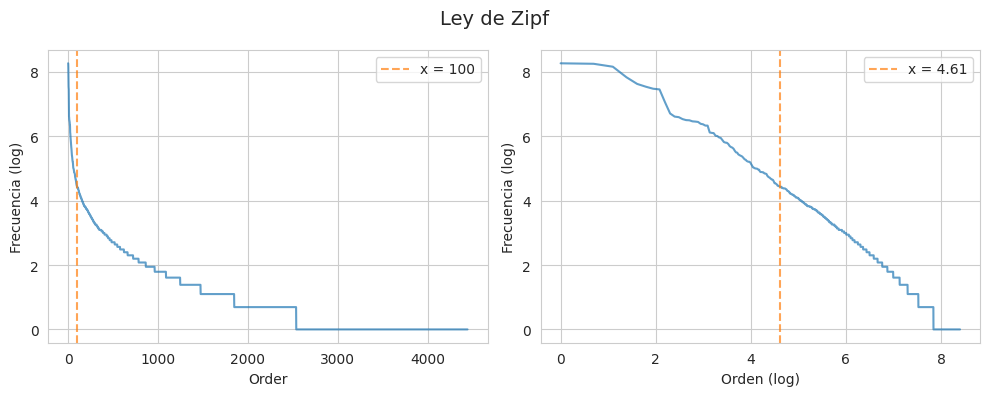

In [70]:
title = "Ley de Zipf"
order = 100

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for i, x in enumerate(["order", "log_order"]):
    sns.lineplot(x=zipf_law[x], y=zipf_law["log_count"], ax=axs[i], alpha=.7)
    axs[i].set_ylabel("Frecuencia (log)")
    if "log" in x:
        xlabel = "Orden (log)"
        xline = math.log(order)
    else:
        xlabel = "Order"
        xline = order
    axs[i].set_xlabel(xlabel)
    axs[i].axvline(
        x=xline, color="#ff7f0e", alpha=.7, linestyle="--",
        label=f"x = {round(xline, 2)}"
    )
    axs[i].legend()

plt.suptitle(title, size=14)
plt.tight_layout()

filename = title.lower().replace(" ", "_")
plt.savefig(os.path.join(VISUALIZATIONS_PATH, filename))